<a href="https://colab.research.google.com/github/juancruzalbornoz/ProyectoDS/blob/main/ProyectoDSParteIAlbornozJuanCruz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# --- Parámetros de Configuración ---
num_rows = 2100
start_date = datetime(2020, 1, 1)
end_date = datetime(2024, 12, 31)
null_probability = 0.08 # Probabilidad de que un valor sea nulo en columnas seleccionadas

# --- Listas de Valores Categóricos ---
wineries = [f'Bodega_{chr(65+i)}' for i in range(10)] # Bodega_A, Bodega_B, ...
regions = ['Mendoza', 'San Juan', 'Salta', 'La Rioja', 'Patagonia']
grape_types = ['Malbec', 'Cabernet Sauvignon', 'Bonarda', 'Syrah', 'Merlot', 'Chardonnay', 'Torrontés']
weather_conditions = ['Soleado', 'Nublado', 'Lluvioso', 'Variable']
barrel_types = ['Roble Francés', 'Roble Americano', 'Acero Inoxidable', 'Sin Crianza']

# --- Generación de Datos ---
data = {}

# IDs únicos
data['ID_Lote'] = range(1, num_rows + 1)

# Fechas
production_dates = [start_date + timedelta(days=random.randint(0, (end_date - start_date).days)) for _ in range(num_rows)]
data['Fecha_Produccion'] = production_dates
# La cosecha debe ser anterior a la producción
data['Fecha_Cosecha'] = [d - timedelta(days=random.randint(30, 180)) for d in production_dates]

# Datos Categóricos
data['Bodega'] = random.choices(wineries, k=num_rows)
data['Region'] = random.choices(regions, k=num_rows)
data['Tipo_Uva'] = random.choices(grape_types, k=num_rows)
data['Clima_Cosecha'] = random.choices(weather_conditions, k=num_rows)

# Datos Numéricos (con algo de lógica y aleatoriedad)
data['Cantidad_Uva_Kg'] = np.random.uniform(1000, 15000, num_rows).round(2)
data['Temp_Prom_Cosecha_C'] = np.random.uniform(15, 30, num_rows).round(1)
data['Tiempo_Fermentacion_Dias'] = np.random.randint(7, 25, num_rows)
data['Temp_Fermentacion_C'] = np.random.uniform(18, 32, num_rows).round(1)

# Crianza y tipo de barril (con cierta correlación)
aging_times = []
barrel_selection = []
for _ in range(num_rows):
    barrel = random.choice(barrel_types)
    barrel_selection.append(barrel)
    if barrel in ['Acero Inoxidable', 'Sin Crianza']:
        aging_times.append(0) # Sin crianza en madera
    else:
        aging_times.append(random.randint(3, 24)) # Meses de crianza
data['Tiempo_Crianza_Meses'] = aging_times
data['Tipo_Barrica'] = barrel_selection

data['Nivel_Acidez_pH'] = np.random.uniform(3.0, 4.2, num_rows).round(2)
data['Contenido_Alcohol_Pct'] = np.random.uniform(11.5, 15.5, num_rows).round(1)

# Calidad (influenciada ligeramente por otros factores para realismo)
base_quality = np.random.randint(75, 95, num_rows)
quality_adjustment = (np.array(data['Tiempo_Crianza_Meses']) / 6) - abs(np.array(data['Temp_Fermentacion_C']) - 25) / 5 # Ajuste simple
data['Puntaje_Calidad'] = np.clip(base_quality + quality_adjustment, 70, 100).round(0).astype(int) # Puntaje 70-100

# Producción y Costos/Precios
# Aprox. 0.6 a 0.8 litros por kg -> 0.8 a 1.1 botellas de 750ml por kg
yield_factor = np.random.uniform(0.8, 1.1, num_rows)
data['Botellas_Producidas'] = (data['Cantidad_Uva_Kg'] * yield_factor).round(0).astype(int)

base_cost = np.random.uniform(1.5, 5.0, num_rows)
cost_adjustment = (np.array(data['Tiempo_Crianza_Meses']) * 0.15) + (np.array(data['Cantidad_Uva_Kg']) / 5000) # Más crianza/volumen = más costo
data['Costo_Produccion_x_Botella'] = (base_cost + cost_adjustment).round(2)

base_price_factor = np.random.uniform(1.8, 3.5, num_rows)
price_adjustment = (np.array(data['Puntaje_Calidad']) - 80) * 0.1 + (np.array(data['Tiempo_Crianza_Meses']) * 0.05)
precio_calculado = (np.array(data['Costo_Produccion_x_Botella']) * base_price_factor + price_adjustment).round(2)
precio_minimo = np.array(data['Costo_Produccion_x_Botella']) * 1.1
data['Precio_Mercado_x_Botella'] = np.maximum(precio_calculado, precio_minimo) # Precio siempre >= 110% del costo

# --- Crear DataFrame ---
df = pd.DataFrame(data)

# --- Introducir Valores Nulos (NaN) ---
cols_with_nulls = [
    'Temp_Prom_Cosecha_C',
    'Nivel_Acidez_pH',
    'Tipo_Barrica', # Puede ser nulo si no se registró
    'Precio_Mercado_x_Botella' # Puede ser nulo si aún no se vende
]

for col in cols_with_nulls:
    # Asegurarse de que la columna puede manejar NaN (convertir a float si es int)
    if pd.api.types.is_integer_dtype(df[col]):
        # Verificar si np.nan es compatible con el tipo de datos de la columna
        if not pd.api.types.is_float_dtype(df[col]):
            df[col] = df[col].astype(float) # Convertir a float para permitir NaN

    mask = np.random.choice([True, False], size=num_rows, p=[null_probability, 1 - null_probability])
    if pd.api.types.is_object_dtype(df[col]): # Para columnas de texto/object
        df.loc[mask, col] = None
    else: # Para columnas numéricas
        df.loc[mask, col] = np.nan


# --- Añadir Columna Derivada para Clasificación ---
# Definir los límites (bins) y las etiquetas para las categorías de calidad
bins = [69, 84, 92, 101] # Límites: (69-84], (84-92], (92-101]
labels = ['Standard', 'Premium', 'Super Premium']

# Crear la nueva columna 'Categoria_Calidad'
df['Categoria_Calidad'] = pd.cut(df['Puntaje_Calidad'], bins=bins, labels=labels, right=True)

# --- Mostrar Información y Salida (Opcional) ---
print("--- Primeras 5 filas del DataFrame ---")
print(df.head().to_markdown(index=False))
print("\n--- Información del DataFrame (Tipos de datos y Nulos) ---")
df.info()
print("\n--- Distribución de Categoria_Calidad ---")
print(df['Categoria_Calidad'].value_counts())

# --- Generar Salida CSV (Opcional) ---
# df.to_csv('produccion_vino_datos_clasificacion.csv', index=False, encoding='utf-8')
# print("\nArchivo 'produccion_vino_datos_clasificacion.csv' generado exitosamente.")

--- Primeras 5 filas del DataFrame ---
|   ID_Lote | Fecha_Produccion    | Fecha_Cosecha       | Bodega   | Region    | Tipo_Uva           | Clima_Cosecha   |   Cantidad_Uva_Kg |   Temp_Prom_Cosecha_C |   Tiempo_Fermentacion_Dias |   Temp_Fermentacion_C |   Tiempo_Crianza_Meses | Tipo_Barrica    |   Nivel_Acidez_pH |   Contenido_Alcohol_Pct |   Puntaje_Calidad |   Botellas_Producidas |   Costo_Produccion_x_Botella |   Precio_Mercado_x_Botella | Categoria_Calidad   |
|----------:|:--------------------|:--------------------|:---------|:----------|:-------------------|:----------------|------------------:|----------------------:|---------------------------:|----------------------:|-----------------------:|:----------------|------------------:|------------------------:|------------------:|----------------------:|-----------------------------:|---------------------------:|:--------------------|
|         1 | 2024-10-06 00:00:00 | 2024-07-24 00:00:00 | Bodega_J | Salta     | Cabernet Sauvign

In [ ]:
df_1 = df.copy()

In [ ]:
df_1.head()

,ID_Lote,Fecha_Produccion,Fecha_Cosecha,Bodega,Region,Tipo_Uva,Clima_Cosecha,Cantidad_Uva_Kg,Temp_Prom_Cosecha_C,Tiempo_Fermentacion_Dias,Temp_Fermentacion_C,Tiempo_Crianza_Meses,Tipo_Barrica,Nivel_Acidez_pH,Contenido_Alcohol_Pct,Puntaje_Calidad,Botellas_Producidas,Costo_Produccion_x_Botella,Precio_Mercado_x_Botella,Categoria_Calidad
0,1,2024-10-06,2024-07-24,Bodega_J,Salta,Cabernet Sauvignon,Variable,12804.48,28.1,19,28.0,0,Sin Crianza,3.67,15.5,91,10283,6.85,24.68,Premium
1,2,2023-03-29,2022-11-14,Bodega_C,Mendoza,Malbec,Soleado,7247.09,20.4,24,19.0,20,Roble Americano,3.47,13.1,88,7653,8.14,28.13,Premium
2,3,2021-01-30,2020-09-07,Bodega_E,Salta,Syrah,Soleado,10421.13,29.5,12,18.9,6,Roble Francés,3.76,13.9,83,8566,7.89,17.69,Standard
3,4,2021-03-09,2020-09-29,Bodega_B,Patagonia,Malbec,Variable,2490.74,28.9,20,23.0,15,Roble Americano,3.15,13.8,87,2039,6.62,24.01,Premium
4,5,2024-08-14,2024-06-11,Bodega_B,Patagonia,Torrontés,Variable,13103.76,19.2,18,23.2,0,None,3.66,15.0,87,13582,6.20,NaN,Premium


In [ ]:
df_1.tail()

,ID_Lote,Fecha_Produccion,Fecha_Cosecha,Bodega,Region,Tipo_Uva,Clima_Cosecha,Cantidad_Uva_Kg,Temp_Prom_Cosecha_C,Tiempo_Fermentacion_Dias,Temp_Fermentacion_C,Tiempo_Crianza_Meses,Tipo_Barrica,Nivel_Acidez_pH,Contenido_Alcohol_Pct,Puntaje_Calidad,Botellas_Producidas,Costo_Produccion_x_Botella,Precio_Mercado_x_Botella,Categoria_Calidad
2095,2096,2023-04-14,2022-10-31,Bodega_D,Salta,Bonarda,Variable,8584.99,19.7,9,23.9,21,None,3.61,11.9,79,7544,8.46,NaN,Standard
2096,2097,2024-02-23,2023-10-31,Bodega_I,Mendoza,Cabernet Sauvignon,Lluvioso,5098.90,25.6,22,24.5,0,Sin Crianza,4.13,12.4,88,5298,4.11,13.69,Premium
2097,2098,2022-04-26,2022-03-25,Bodega_I,Salta,Merlot,Lluvioso,14826.69,19.6,21,27.4,0,Acero Inoxidable,NaN,11.9,75,15841,7.75,13.92,Standard
2098,2099,2022-08-27,2022-06-19,Bodega_D,La Rioja,Merlot,Variable,13216.73,29.8,17,23.5,16,Roble Americano,3.47,13.8,87,11533,9.99,NaN,Premium
2099,2100,2021-02-09,2020-11-18,Bodega_C,San Juan,Merlot,Nublado,1873.75,16.9,8,22.0,12,Roble Americano,NaN,11.7,88,1866,6.22,16.99,Premium


In [ ]:
df_1.shape

(2100, 20)

In [ ]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ID_Lote                     2100 non-null   int64         
 1   Fecha_Produccion            2100 non-null   datetime64[ns]
 2   Fecha_Cosecha               2100 non-null   datetime64[ns]
 3   Bodega                      2100 non-null   object        
 4   Region                      2100 non-null   object        
 5   Tipo_Uva                    2100 non-null   object        
 6   Clima_Cosecha               2100 non-null   object        
 7   Cantidad_Uva_Kg             2100 non-null   float64       
 8   Temp_Prom_Cosecha_C         1924 non-null   float64       
 9   Tiempo_Fermentacion_Dias    2100 non-null   int64         
 10  Temp_Fermentacion_C         2100 non-null   float64       
 11  Tiempo_Crianza_Meses        2100 non-null   int64       

In [ ]:
df.dtypes

,0
ID_Lote,int64
Fecha_Produccion,datetime64[ns]
Fecha_Cosecha,datetime64[ns]
Bodega,object
Region,object
Tipo_Uva,object
Clima_Cosecha,object
Cantidad_Uva_Kg,float64
Temp_Prom_Cosecha_C,float64
Tiempo_Fermentacion_Dias,int64


In [ ]:
df.describe

<bound method NDFrame.describe of       ID_Lote Fecha_Produccion Fecha_Cosecha    Bodega     Region  \
0           1       2024-10-06    2024-07-24  Bodega_J      Salta   
1           2       2023-03-29    2022-11-14  Bodega_C    Mendoza   
2           3       2021-01-30    2020-09-07  Bodega_E      Salta   
3           4       2021-03-09    2020-09-29  Bodega_B  Patagonia   
4           5       2024-08-14    2024-06-11  Bodega_B  Patagonia   
...       ...              ...           ...       ...        ...   
2095     2096       2023-04-14    2022-10-31  Bodega_D      Salta   
2096     2097       2024-02-23    2023-10-31  Bodega_I    Mendoza   
2097     2098       2022-04-26    2022-03-25  Bodega_I      Salta   
2098     2099       2022-08-27    2022-06-19  Bodega_D   La Rioja   
2099     2100       2021-02-09    2020-11-18  Bodega_C   San Juan   

                Tipo_Uva Clima_Cosecha  Cantidad_Uva_Kg  Temp_Prom_Cosecha_C  \
0     Cabernet Sauvignon      Variable         12804.48                 28.1   
1                 Malbec       Soleado          7247.09                 20.4   
2                  Syrah       Soleado         10421.13                 29.5   
3                 Malbec      Variable          2490.74                 28.9   
4              Torrontés      Variable         13103.76                 19.2   
...                  ...           ...              ...                  ...   
2095             Bonarda      Variable          8584.99                 19.7   
2096  Cabernet Sauvignon      Lluvioso          5098.90                 25.6   
2097              Merlot      Lluvioso         14826.69                 19.6   
2098              Merlot      Variable         13216.73                 29.8   
2099              Merlot       Nublado          1873.75                 16.9   

      Tiempo_Fermentacion_Dias  Temp_Fermentacion_C  Tiempo_Crianza_Meses  \
0                           19                 28.0                     0   
1                           24                 19.0                    20   
2                           12                 18.9                     6   
3                           20                 23.0                    15   
4                           18                 23.2                     0   
...                        ...                  ...                   ...   
2095                         9                 23.9                    21   
2096                        22                 24.5                     0   
2097                        21                 27.4                     0   
2098                        17                 23.5                    16   
2099                         8                 22.0                    12   

          Tipo_Barrica  Nivel_Acidez_pH  Contenido_Alcohol_Pct  \
0          Sin Crianza             3.67                   15.5   
1      Roble Americano             3.47                   13.1   
2        Roble Francés             3.76                   13.9   
3      Roble Americano             3.15                   13.8   
4                 None             3.66                   15.0   
...                ...              ...                    ...   
2095              None             3.61                   11.9   
2096       Sin Crianza             4.13                   12.4   
2097  Acero Inoxidable              NaN                   11.9   
2098   Roble Americano             3.47                   13.8   
2099   Roble Americano              NaN                   11.7   

      Puntaje_Calidad  Botellas_Producidas  Costo_Produccion_x_Botella  \
0                  91                10283                        6.85   
1                  88                 7653                        8.14   
2                  83                 8566                        7.89   
3                  87                 2039                        6.62   
4                  87                13582                        6.20   
...           

In [ ]:
# Importación de librerías fundamentales
import pandas as pd
import numpy as np

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Librería especializada en visualización de datos ausentes
# Si no está instalada, descomentar y ejecutar la siguiente línea en Colab:
# !pip install missingno
import missingno as msno

# Librerías de Scikit-learn para imputación
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split # Para demostrar buenas prácticas

# Configuraciones adicionales (opcional)
pd.set_option('display.max_columns', None) # Mostrar todas las columnas
sns.set_style('whitegrid') # Estilo de gráficos Seaborn
plt.rcParams['figure.figsize'] = (10, 6) # Tamaño de figuras Matplotlib

In [ ]:
# Contar valores nulos por columna
print("Conteo de valores nulos por columna:")
print(df_1.isnull().sum())

# Calcular el porcentaje de valores nulos por columna
print("\nPorcentaje de valores nulos por columna:")
print((df_1.isnull().sum() / len(df)) * 100)

Conteo de valores nulos por columna:
ID_Lote                         0
Fecha_Produccion                0
Fecha_Cosecha                   0
Bodega                          0
Region                          0
Tipo_Uva                        0
Clima_Cosecha                   0
Cantidad_Uva_Kg                 0
Temp_Prom_Cosecha_C           176
Tiempo_Fermentacion_Dias        0
Temp_Fermentacion_C             0
Tiempo_Crianza_Meses            0
Tipo_Barrica                  164
Nivel_Acidez_pH               185
Contenido_Alcohol_Pct           0
Puntaje_Calidad                 0
Botellas_Producidas             0
Costo_Produccion_x_Botella      0
Precio_Mercado_x_Botella      158
Categoria_Calidad               0
dtype: int64

Porcentaje de valores nulos por columna:
ID_Lote                       0.000000
Fecha_Produccion              0.000000
Fecha_Cosecha                 0.000000
Bodega                        0.000000
Region                        0.000000
Tipo_Uva                      0.0

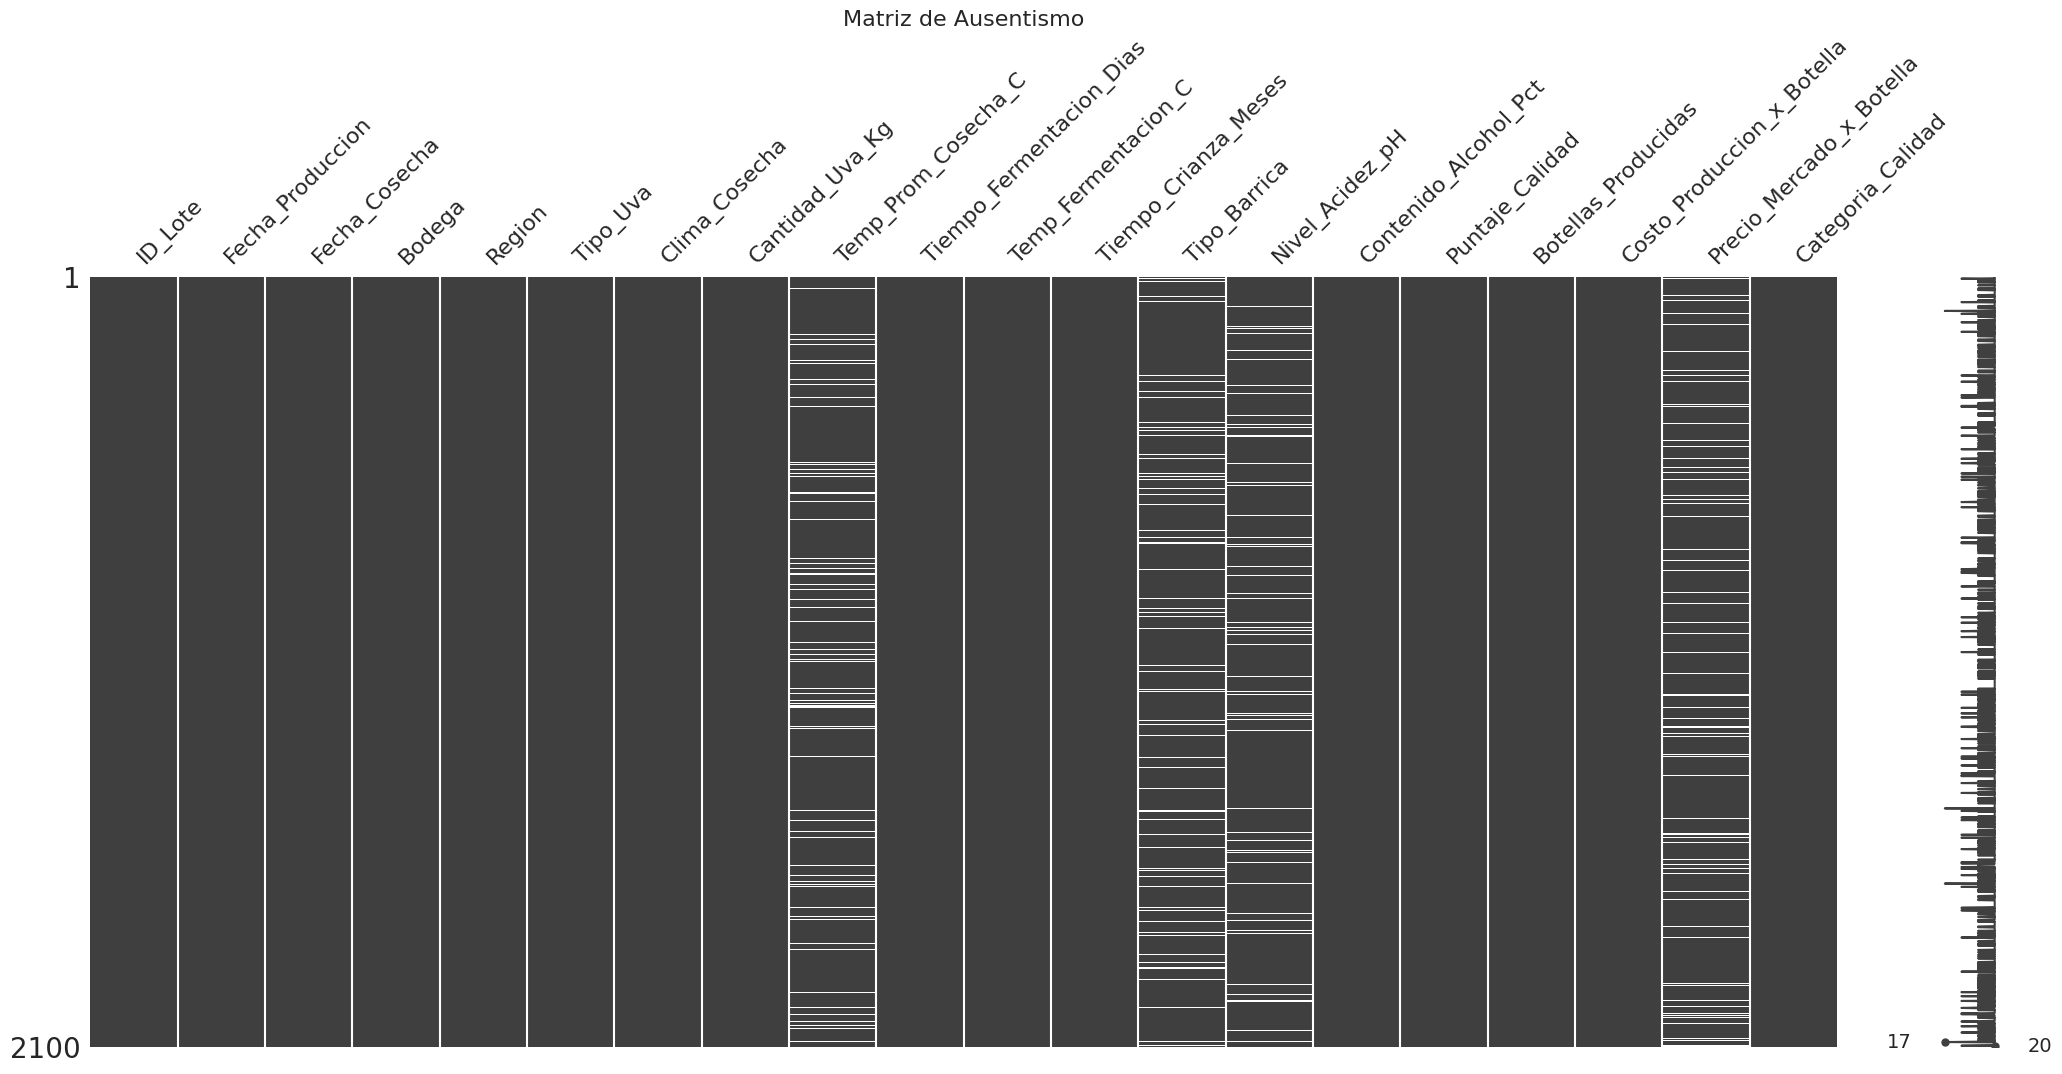

In [ ]:
# Matriz de ausentismo: visualiza la ubicación de los NaN
msno.matrix(df_1)
plt.title('Matriz de Ausentismo', fontsize=16)
plt.show()

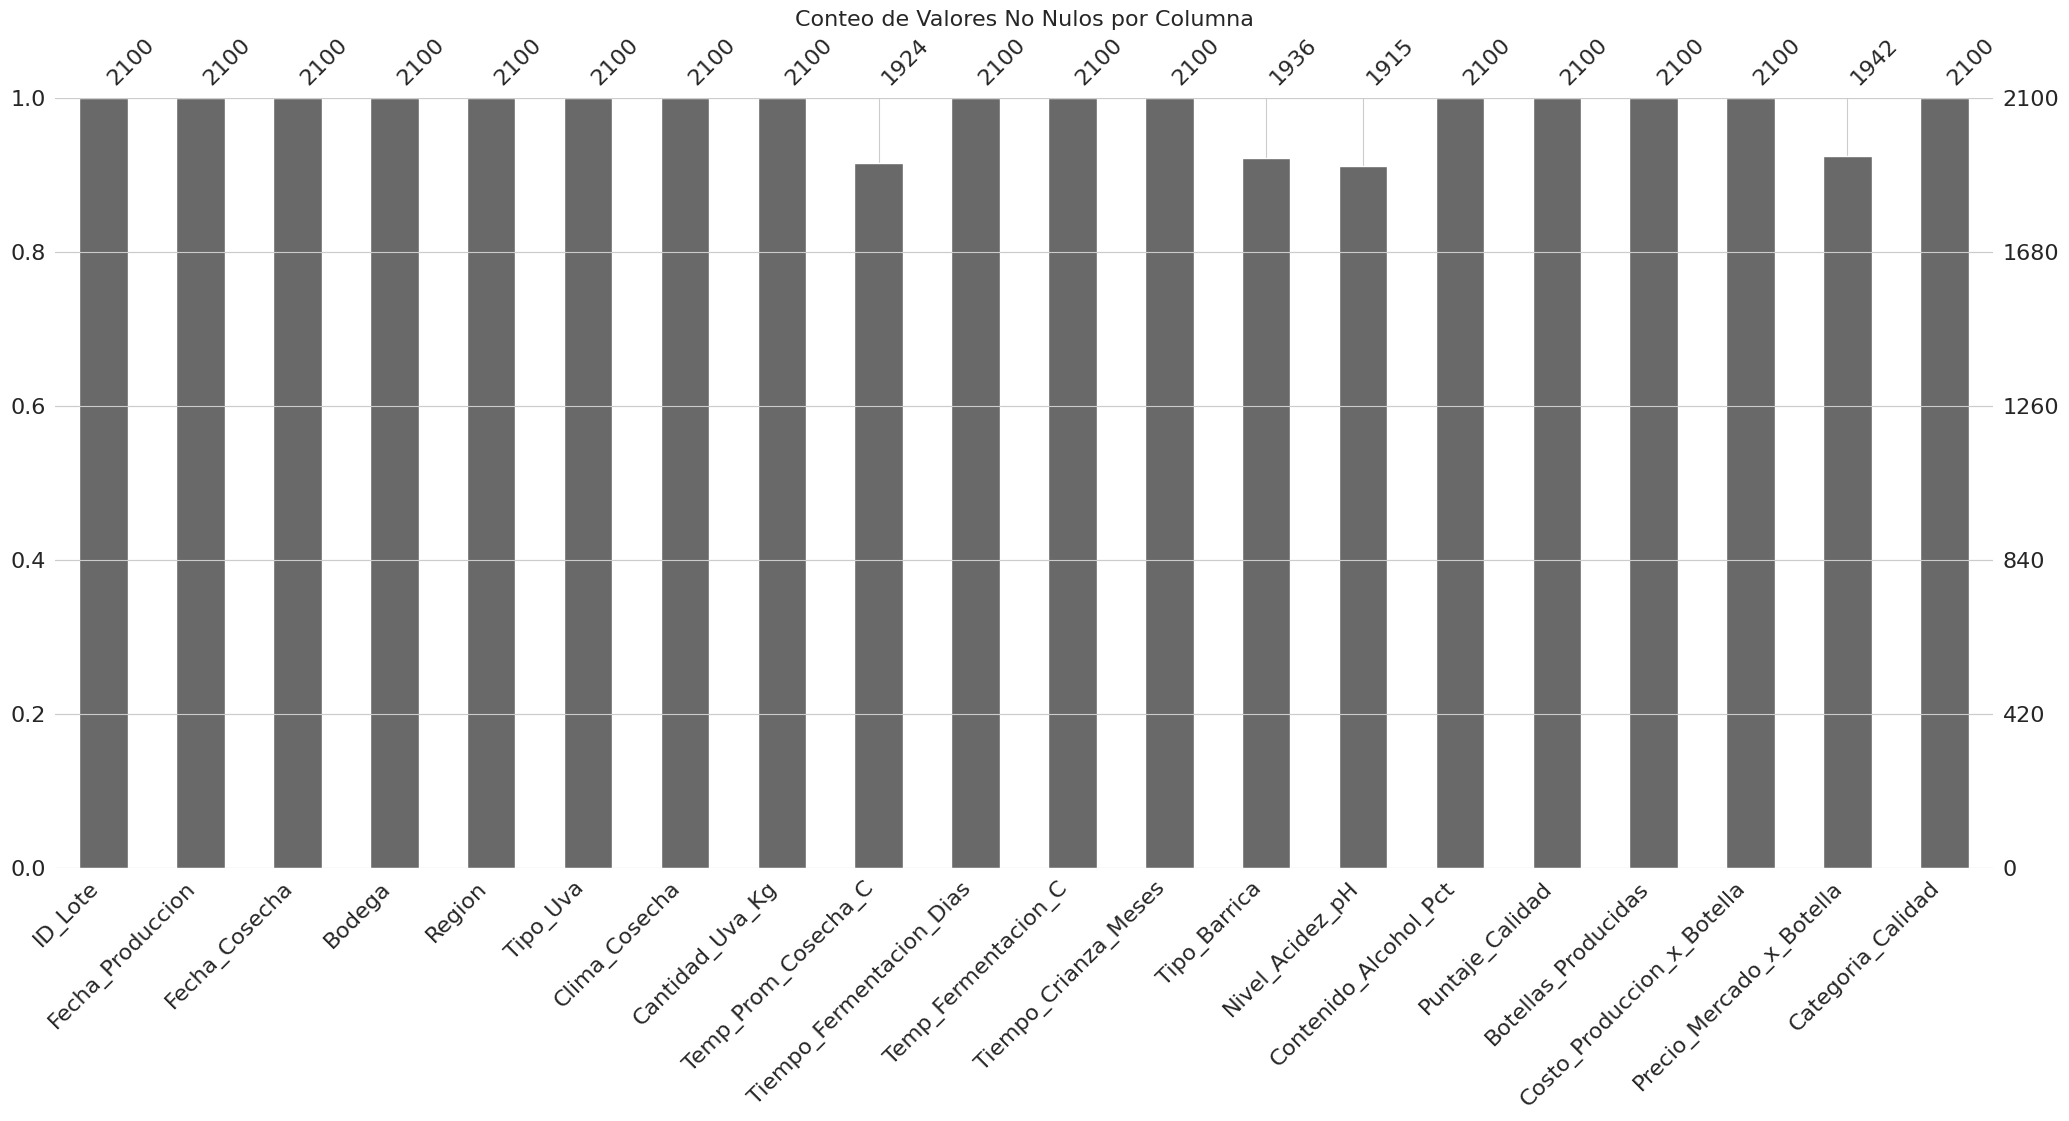

In [ ]:
# Gráfico de barras de ausentismo: similar a .isnull().sum() pero gráfico
msno.bar(df_1)
plt.title('Conteo de Valores No Nulos por Columna', fontsize=16)
plt.show()

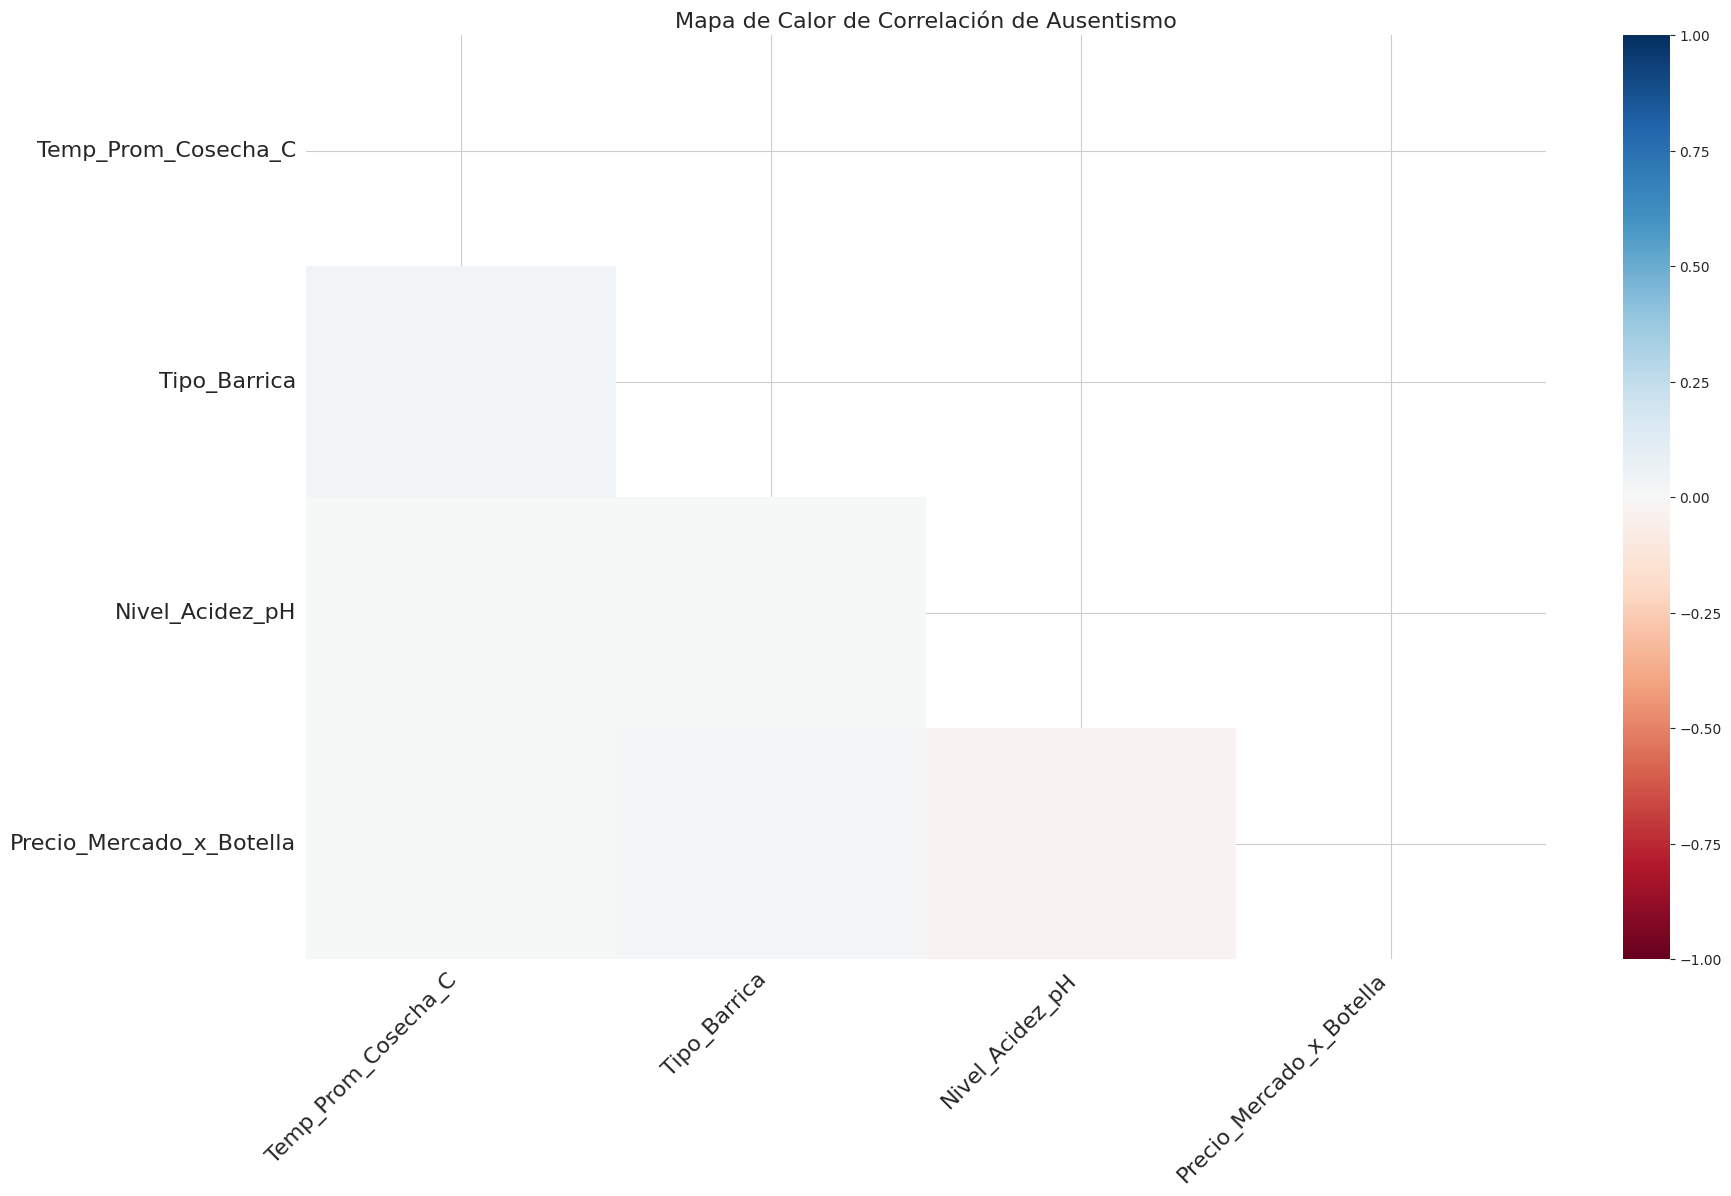

In [ ]:
# Mapa de calor de correlación de ausentismo:
# Muestra si la ausencia de valor en una variable se relaciona con la ausencia en otra.
# Una correlación cercana a 1 significa que si falta un dato en A, es muy probable que falte en B.
# Una correlación cercana a -1 significa que si falta un dato en A, es muy probable que NO falte en B.
# Cerca de 0 indica poca relación lineal en la ausentismo.
msno.heatmap(df_1)
plt.title('Mapa de Calor de Correlación de Ausentismo', fontsize=16)
plt.show()

In [ ]:
# Crear una copia
df_imputado_mediana = df_1.copy()

# Seleccionar columnas numéricas (excluyendo ID)
columnas_numericas = df_imputado_mediana.select_dtypes(include=np.number).columns.drop('ID_Lote')

# Calcular la mediana para cada columna numérica
medianas = df_imputado_mediana[columnas_numericas].median()
print("Medianas calculadas:\n", medianas)

# Imputar los NaN con la mediana correspondiente
for col in columnas_numericas:
    df_imputado_mediana[col].fillna(medianas[col], inplace=True)

Medianas calculadas:
 Cantidad_Uva_Kg               7657.00
Temp_Prom_Cosecha_C             22.45
Tiempo_Fermentacion_Dias        15.00
Temp_Fermentacion_C             25.00
Tiempo_Crianza_Meses             3.00
Nivel_Acidez_pH                  3.60
Contenido_Alcohol_Pct           13.40
Puntaje_Calidad                 85.00
Botellas_Producidas           7347.50
Costo_Produccion_x_Botella       5.75
Precio_Mercado_x_Botella        15.51
dtype: float64


<ipython-input-23-fa106a90c933>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputado_mediana[col].fillna(medianas[col], inplace=True)


In [ ]:
print("\nDataFrame después de imputación por media:")
df_imputado_mediana.isnull().sum() # Verificar que no hay nulos numéricos


DataFrame después de imputación por media:


,0
ID_Lote,0
Fecha_Produccion,0
Fecha_Cosecha,0
Bodega,0
Region,0
Tipo_Uva,0
Clima_Cosecha,0
Cantidad_Uva_Kg,0
Temp_Prom_Cosecha_C,0
Tiempo_Fermentacion_Dias,0


In [ ]:
# Crear una copia (usaremos la copia imputada por mediana para las numéricas)
df_imputado_moda = df_imputado_mediana.copy() # Partimos de un DF con numéricos ya imputados

# Seleccionar columnas categóricas y booleanas (que trataremos como categóricas aquí)
columnas_categoricas = df_imputado_moda.select_dtypes(include=['object']).columns

# Imputar los NaN con "None"
for col in columnas_categoricas:
    df_imputado_moda[col].fillna("None", inplace=True)

<ipython-input-26-3f5b0e5a68d0>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputado_moda[col].fillna("None", inplace=True)


In [ ]:
print("\nDataFrame después de imputación por moda (categóricas):")
df_imputado_moda.isnull().sum() # Verificar que no quedan nulos


DataFrame después de imputación por moda (categóricas):


,0
ID_Lote,0
Fecha_Produccion,0
Fecha_Cosecha,0
Bodega,0
Region,0
Tipo_Uva,0
Clima_Cosecha,0
Cantidad_Uva_Kg,0
Temp_Prom_Cosecha_C,0
Tiempo_Fermentacion_Dias,0
